In [2]:
import datasets

dataset = datasets.load_dataset('cifar10', split='train', ignore_verifications=False)
dataset

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/datasets/load.py:2555: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(


Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [3]:
dataset_test = datasets.load_dataset('cifar10', split='test', ignore_verifications=False)
dataset_test

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [6]:
num_classes = len(set(dataset['label']))
labels = dataset.features['label']
labels

ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)

airplane


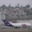

In [12]:
print(labels.names[dataset[0]['label']])
dataset[0]['img']

In [14]:
from transformers import ViTFeatureExtractor

model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor(model_id)
feature_extractor

ViTFeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": "google/vit-base-patch16-224-in21k",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [21]:
example = feature_extractor(dataset[0]['img'])
print(example.keys())
len(example['pixel_values'])
example['pixel_values'][0].shape

dict_keys(['pixel_values'])


(3, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


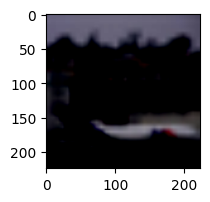

In [29]:
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rc('figure', figsize=(4, 2))

plt.imshow(example['pixel_values'][0].transpose(1, 2, 0));

In [32]:
import torch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device', device)

device cpu


In [34]:
def preprocess(batch):
    inputs = feature_extractor(batch['img'], return_tensors='pt')
    inputs['label'] = batch['label']
    return inputs

In [36]:
prepared_train = dataset.with_transform(preprocess)
prepared_test = dataset_test.with_transform(preprocess)

In [37]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([ele['pixel_values'] for ele in batch['pixel_values']]),
        'labels': torch.tensor([ele['label'] for ele in batch['label']]),
    }

In [40]:
from datasets import load_metric
metric = load_metric('accuracy')
def compute_metrics(p):
    return metric.compute(
        prediction = np.argmax(p.predictions, axis=1),
        references = p.label_ids
    )

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
